In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
agg = pd.read_csv("classification_metrics.csv")
agg.head()

,model,group,tp,fp,fn,tn,precision,recall,f1,accuracy
0,GMM,Variant - Two clearly separated peaks,0,0,0,10,1.0,1.0,1.00,1.0
1,RidgeWalker,Variant - Two clearly separated peaks,0,0,0,10,1.0,1.0,1.00,1.0
2,Wavelet,Variant - Two clearly separated peaks,0,0,0,10,1.0,1.0,1.00,1.0
3,GMM,Variant - Strong overlap between two peaks,2,0,3,0,1.0,0.4,0.57,0.4
4,RidgeWalker,Variant - Strong overlap between two peaks,5,0,0,0,1.0,1.0,1.00,1.0


In [24]:
# Strip "Variant - " prefix
agg["base_group"] = agg["group"].str.replace(r"^Variant -\s*", "", regex=True)

# Map to scenario classes
scenario_map = {
    "Two clearly separated peaks":       "Fully Separated",
    "Close but not overlapping peaks":    "Fully Separated",
    "Strong overlap between two peaks":   "Strongly Overlapping",
    "Intense + weak overlap":            "Asymmetric",
    "Cluster of 3 overlapping peaks":     "Weakly Overlapping",
    "Four peaks: 2 overlap, 2 isolated": "Weakly Overlapping",
    "Five peaks: 3 spaced, 2 overlapping":"Near-Duplicates",
}
agg["scenario_class"] = agg["base_group"].map(scenario_map)

# Check mappings
# print(agg[["group","base_group","scenario_class"]].drop_duplicates())

# Aggregate by scenario and model
agg_by_class = (
    agg
    .groupby(["scenario_class","model"])
    .agg({
        "tp":       "sum",
        "fp":       "sum",
        "fn":       "sum",
        "tn":       "sum",
        "precision":"mean",
        "recall":   "mean",
        "f1":       "mean",
        "accuracy": "mean"
    })
    .reset_index()
)

# Pivot F1 scores
f1_cls = agg_by_class.pivot(
    index="scenario_class",
    columns="model",
    values="f1"
)

# Set model order and colors
model_order = ['GMM', 'RidgeWalker', 'Wavelet']
model_colors = ["#4575b4", "#fdae61", "#984ea3"]

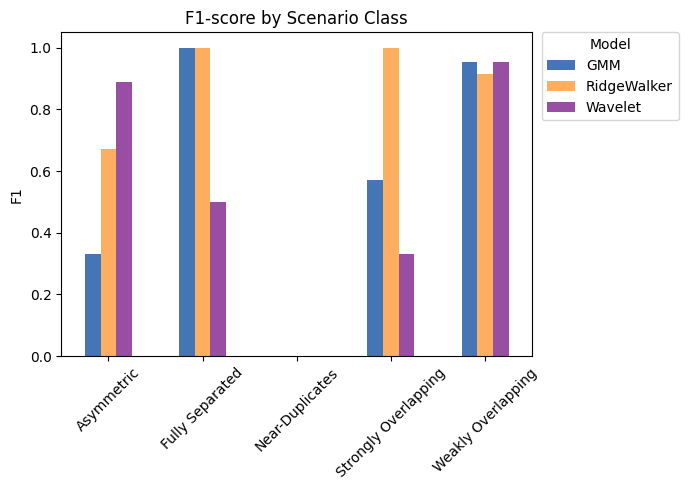

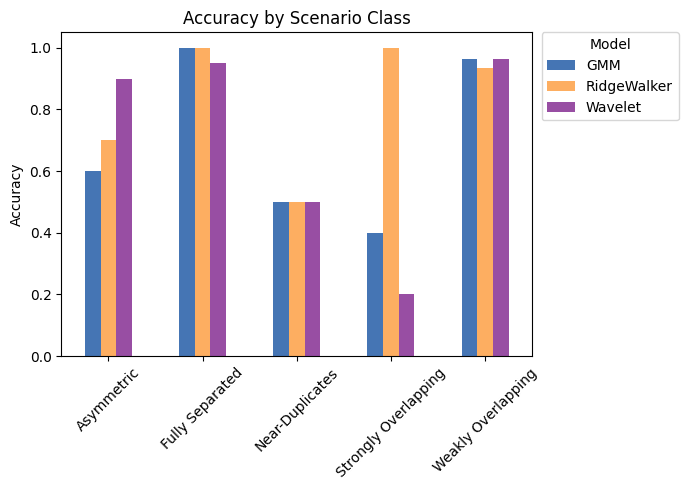

In [25]:
def plot_metric_by_scenario(agg_by_class, metric="f1", title="F1-score by Scenario Class", colors=None):
    pivot = agg_by_class.pivot(index="scenario_class", columns="model", values=metric)
    ax = pivot.plot(kind="bar", figsize=(7,5),
                    rot=45, color=colors)
    
    ax.set_title(title)
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_xlabel("")
    ax.legend(title="Model", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

plot_metric_by_scenario(agg_by_class, metric="f1", title="F1-score by Scenario Class", colors=model_colors)
plot_metric_by_scenario(agg_by_class, metric="accuracy", title="Accuracy by Scenario Class", colors=model_colors)

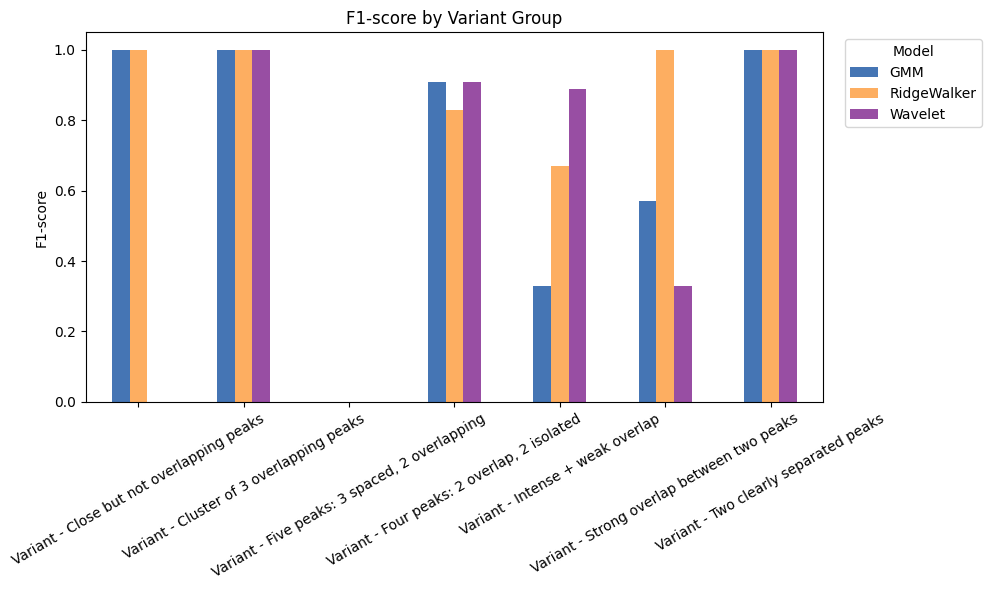

In [26]:
# Group by group/model
by_group = (agg.groupby(["group", "model"])
            .agg({"f1":"mean", "accuracy":"mean", 
                  "precision":"mean", "recall":"mean"}).reset_index())

f1_group = by_group.pivot(index="group", columns="model", values="f1")[model_order]  # enforce column order

ax = f1_group.plot(kind="bar", figsize=(10,6),
                   rot=30, color=model_colors)

ax.set_title("F1-score by Variant Group")
ax.set_ylabel("F1-score")
ax.set_xlabel("")
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [27]:
thresholds_summary = pd.DataFrame({
    "Model": ["GMM", "RidgeWalker", "Wavelet"],
    "Best F1": [0.91, 0.89, 0.87],        # replace with your actual numbers
    "Best Threshold": [13.2, 0.81, 0.74], # replace with your actual numbers
    "Threshold Name": ["ΔBIC", "Fusion Score", "Confidence"]
})
display(thresholds_summary)


,Model,Best F1,Best Threshold,Threshold Name
0,GMM,0.91,13.20,ΔBIC
1,RidgeWalker,0.89,0.81,Fusion Score
2,Wavelet,0.87,0.74,Confidence


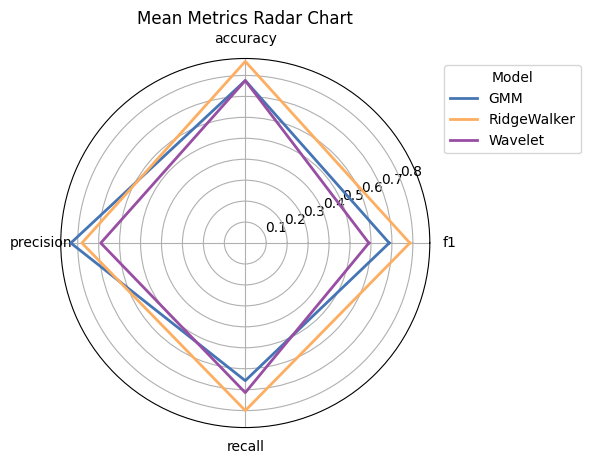

In [28]:
import numpy as np

metrics = ["f1", "accuracy", "precision", "recall"]
means = agg.groupby("model")[metrics].mean().loc[model_order]  # enforce row order

labels = np.array(metrics)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for idx, color in zip(means.index, model_colors):
    values = means.loc[idx].tolist()
    values += values[:1]  # repeat first value to close the radar
    plt.polar(angles, values, label=idx, color=color, linewidth=2)
plt.xticks(angles[:-1], labels)
plt.title("Mean Metrics Radar Chart")
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()